<a href="https://colab.research.google.com/github/IrfanChairurrachman/BPML-Dicoding/blob/master/submission2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2>Time Series

<b>sampel data</b>: https://www.kaggle.com/pankrzysiu/weather-archive-jena (deskripsi data dapat dilihat di sini)

Sampel data adalah data cuaca Jena dari tahun 2009 sampai tahun 2016. data didownload dari https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [ ]:
!wget --no-check-certificate \
  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip \
  -O /content/jena_climate_2009_2016.zip

--2020-09-06 14:20:49--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.81.86
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.81.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘/content/jena_climate_2009_2016.zip’

/content/jena_clima 100%[===================>]  12.94M  39.5MB/s    in 0.3s    

2020-09-06 14:20:50 (39.5 MB/s) - ‘/content/jena_climate_2009_2016.zip’ saved [13568290/13568290]



In [ ]:
import os
import zipfile

local_zip = '/content/jena_climate_2009_2016.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
data = pd.read_csv('jena_climate_2009_2016.csv')
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [ ]:
# Karena data terlalu besar maka interval 10 menit diubah menjadi interval 2 jam
data_2 = data[0::12]
data_2.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
12,01.01.2009 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
24,01.01.2009 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9
36,01.01.2009 06:10:00,997.81,-9.59,263.74,-10.47,93.2,2.95,2.74,0.20,1.71,2.75,1317.44,0.24,0.75,161.6
48,01.01.2009 08:10:00,999.27,-8.14,265.08,-9.12,92.6,3.30,3.06,0.24,1.91,3.06,1311.98,0.71,1.00,241.4


In [ ]:
# Melihat apakah ada nilai kosong dalam data
data_2.isnull().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

In [ ]:
# Melihat deskripsi data, termasuk nilai max dan min dari data
# Dapat dilihat jg bahwa jumlah data = 35.046, di atas 10.000
data_2.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000,35046.000000
mean,989.214183,9.450874,283.493364,4.954232,76.000039,13.577290,9.531882,4.045340,6.021190,9.638269,1216.062309,1.841397,2.953584,175.303193
std,8.353391,8.424452,8.505252,6.727681,16.487262,7.740242,4.180972,4.899244,2.654072,4.232115,39.974137,53.445500,75.597152,86.860215
min,942.950000,-22.540000,251.180000,-24.610000,14.200000,0.990000,0.820000,0.000000,0.520000,0.830000,1103.470000,-9999.000000,-9999.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.190000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.472500,0.990000,1.760000,126.700000
50%,989.580000,9.430000,283.490000,5.230000,79.300000,11.830000,8.870000,2.180000,5.600000,8.960000,1213.790000,1.760000,2.960000,198.300000
75%,994.730000,15.490000,289.550000,10.060000,89.500000,17.620000,12.340000,5.310000,7.800000,12.490000,1242.755000,2.850000,4.730000,234.700000
max,1015.190000,37.130000,311.060000,22.400000,100.000000,63.260000,27.140000,45.420000,17.360000,27.620000,1392.100000,28.490000,18.380000,360.000000


In [ ]:
# Mencari batas nilai mae 5% dari skala data
max_mae = (data_2['T (degC)'].max() - data_2['T (degC)'].min()) * 0.05
print(max_mae)

2.9835000000000003


In [ ]:
# Menerapkan callback ketika target mae di bawah target
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_mae') < max_mae):
      print("\nMae dibawah target, hentikan pelatihan")
      self.model.stop_training = True

callbacks = myCallback()

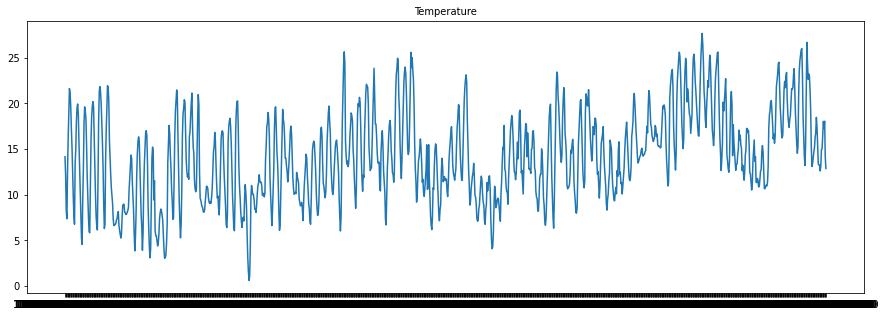

In [ ]:
# Mencoba menerapkan plot terhadap sebagian data
import matplotlib.pyplot as plt

dates = data_2['Date Time'].values
temp  = data_2['T (degC)'].values

plt.figure(figsize=(15,5))
plt.plot(dates[1200:2400], temp[1200:2400])
plt.title('Temperature',
          fontsize=10);

In [ ]:
# Mencari jumlah training data dan val data
train_num = int(len(temp)*0.8)
print(train_num)

28036


In [ ]:
# Mengecek apakah data telah terbagi dengan baik atau tidak
temp_train = temp[:train_num]
temp_val = temp[train_num:]

print(len(temp_train))
print(len(temp_val))

28036
7010


In [ ]:
import numpy as np
import tensorflow as tf
from keras.layers import Dense, LSTM

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
# Menerapkan windowed dataset pada train dan val
train_set = windowed_dataset(temp_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(temp_val, window_size=60, batch_size=100, shuffle_buffer=1000)

# Membuat model
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
val_set

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=30, validation_data=val_set, callbacks=[callbacks])

Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

280/280 [==============================] - 6s 21ms/step - loss: 8.4437 - mae: 8.9299 - val_loss: 7.4563 - val_mae: 7.9396
Epoch 2/30
280/280 [==============================] - 6s 20ms/step - loss: 4.5811 - mae: 5.0586 - val_loss: 3.5545 - val_mae: 4.0220
Epoch 3/30
280/280 [==============================] - 6s 21ms/step - loss: 3.0823 - mae: 3.5484 - val_loss: 2.7882 - val_mae: 3.2507
Epoch 4/30
280/280 [==============================] - 6s 21ms/step - loss: 2.9012 - mae: 3.3659 - val_loss: 2

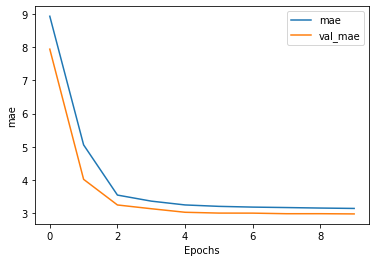

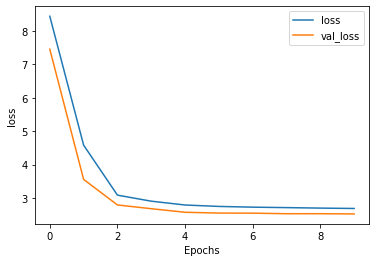

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "mae")
plot_graphs(history, "loss")